## Multi-task learning

Regression + Classification

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
from models.custom_net import *
from models.sfcn_grade import *
from models.resnet import *
from models.inception_resnet_v2 import *
from models.densenet import *
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
from models.ranking_loss import *
from models.focalloss import *

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        # normalized images
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class SEBlock(nn.Module):
    
    def __init__(self, in_channels, r=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels//r),
            nn.ReLU(),
            nn.Linear(in_channels//r, in_channels),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1, 1)
        return x

In [8]:
img_dir = 'img_npy/'
label_dir = 'labels/data_grade_foruse.csv'
label_name = ['Cerebral WM Hypointensities* Total Percent Of Icv', 'Cortical Gray Matter Total Percent Of Icv', 'GRADE']

In [9]:
weight_decay = 1e-6 #0.01
lr = 0.0001
epochs = 100
batch_size = 16
optimizer = optim.Adam
dropout_rate = 0.5
test_size = 0.2
# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
#                                                lr_lambda=lambda epoch: 0.3 ** epoch)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [11]:
class NeckDataset(Dataset):
    def __init__(self, index, X=None, y=None, transform=None):
        self.X = X
#         self.y1 = y[index[0]].values  # 'Cerebral WM Hypointensities* Total Percent Of Icv'
        self.y2 = y[index[1]].values  # 'Cortical Gray Matter Total Percent Of Icv'
        self.y3 = y[index[2]].values  # 'GRADE'
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = torch.FloatTensor(self.X[idx])
#         label1 = torch.FloatTensor(self.y1)[idx]
        label2 = torch.FloatTensor(self.y2)[idx]
        label3 = torch.LongTensor(self.y3)[idx]
        if self.transform is not None:
            image = self.transform(image)
        return [image, label2, label3]

In [12]:
def train(model, train_loader, lr, weight_decay, optim_class=optim.AdamW, scheduler=None, sorter='sodeep/weights/best_model_gruc.pth.tar'):
#     criterion1 = nn.L1Loss()
#     criterion1 = rank_difference_loss(sorter)
#     criterion2 = nn.L1Loss()
    criterion2 = rank_difference_loss(sorter)
#     criterion3 = nn.CrossEntropyLoss()
    criterion3 = FocalLoss(gamma=5)
        
    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    total_loss = 0
    correct = 0
    
    model.train()
    for inputs, labels1, labels2 in tqdm(train_loader):              
        
        # move data to the GPU
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
#         labels3 = labels3.to(device)
        
        # clear previous gradient computation
        optimizer.zero_grad()

        # forward prop
        output1, output2 = model(inputs)
#         print('y: {} / y hat: {}'.format(labels, output))
            
        # calculate loss with cost function
        loss1 = criterion2(output1, labels1.unsqueeze(1).float())
        loss2 = criterion3(output2, labels2)
        loss = loss1 + loss2
        
        # back prop
        loss.backward()
        
        # update model weights
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        # accumulate loss
        total_loss += loss.data.item()
        
#         # accumulate correlation
        
#         # accumulate correct count
#         _, preds = torch.max(output3, 1)
#         correct += torch.sum(preds == labels.data)
                
        gc.collect()
        torch.cuda.empty_cache()
        
    return total_loss

In [13]:
def valid(model, valid_loader, sorter='sodeep/weights/best_model_gruc.pth.tar'):
#     criterion1 = nn.L1Loss()
#     criterion1 = rank_difference_loss(sorter)
#     criterion2 = nn.L1Loss()
    criterion2 = rank_difference_loss(sorter)
#     criterion3 = nn.CrossEntropyLoss()
    criterion3 = FocalLoss(gamma=5)
    
    total_loss = 0
    correct = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels1, labels2 in tqdm(valid_loader):
            
            # move data to the GPU
            inputs = inputs.to(device)
            labels1 = labels1.to(device)
            labels2 = labels2.to(device)
#             labels3 = labels3.to(device)

            # forward prop
            output1, output2 = model(inputs)

            # calculate loss with cost function
            loss1 = criterion2(output1, labels1.unsqueeze(1).float())
            loss2 = criterion3(output2, labels2)
            loss = loss1 + loss2
            
            # accumulate loss
            total_loss += loss.data.item()
            
#             # accumulate correct count
#             _, preds = torch.max(output, 1)
#             correct += torch.sum(preds == labels.data)
                    
    return total_loss

---

In [14]:
# load data
X, y = load_data(img_dir, label_dir, std=False, norm=True)  # std=False, norm=True

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [15]:
# train set
train_set = NeckDataset(label_name, X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16, shuffle=True)

In [16]:
# validation set
valid_set = NeckDataset(label_name, X_test, y_test)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=16, shuffle=False)

In [ ]:
# # plot class distribution histogram
# plt.figure(figsize=(10,4))

# y_train, y_test = [], []
# for _, data in train_set:
#     y_train.append(data)
# for _, data in valid_set:
#     y_test.append(data)

# plt.subplot(1,2,1)
# plt.title('Class distribution in Train Set')
# plt.hist(y_train)

# plt.subplot(1,2,2)
# plt.title('Class distribution in Validation Set')
# plt.hist(y_test)

# plt.show()
# plt.close()

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


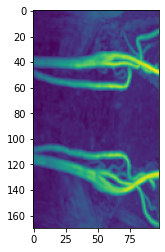

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


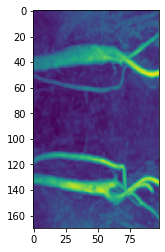

torch.Size([16, 1, 170, 84, 98])
Label = 1 : punctate foci image


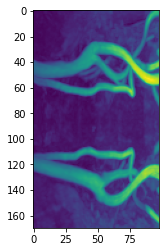

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


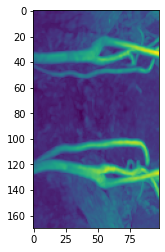

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


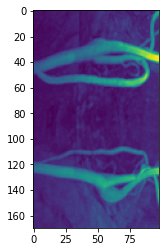

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


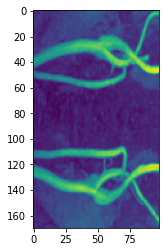

torch.Size([16, 1, 170, 84, 98])
Label = 3 : large confluent areas image


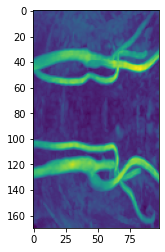

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


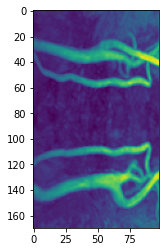

torch.Size([16, 1, 170, 84, 98])
Label = 2 : beginning confluence image


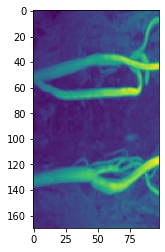

torch.Size([16, 1, 170, 84, 98])
Label = 0 : absent image


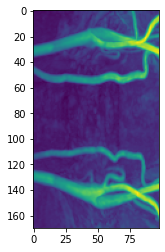

torch.Size([1, 1, 170, 84, 98])
Label = 0 : absent image


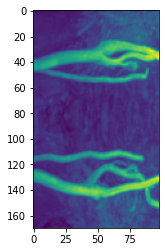

In [17]:
# only for classification
from torch.autograd import Variable

for images, _, labels3 in valid_loader:
    i, l = Variable(images), Variable(labels3)
    print(i.size())
    i = i.cpu().numpy()
    l = l.cpu().numpy()
    if l[0]==0:
        print('Label = {} : absent image'.format(l[0]))
    elif l[0]==1:
        print('Label = {} : punctate foci image'.format(l[0]))
    elif l[0]==2:
        print('Label = {} : beginning confluence image'.format(l[0]))
    else:
        print('Label = {} : large confluent areas image'.format(l[0]))
    plt.imshow(np.max(i[0].squeeze(), axis=1))
    plt.show()

In [ ]:
class ShallowNet(nn.Module):

    def __init__(self, depth=1, classes=4):
        super(ShallowNet, self).__init__()
        
        self.feature_extractor = nn.Sequential()
        
        conv1 = nn.Sequential(
            nn.Conv3d(in_channels=depth, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.ReLU())
        
#         conv2 = nn.Sequential(
#             nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm3d(64),
#             nn.MaxPool3d(kernel_size=2, stride=2),
#             nn.ReLU())
        
#         conv3 = nn.Sequential(
#             nn.Conv3d(in_channels=64, out_channels=64, kernel_size=1, stride=1),
#             nn.BatchNorm3d(64),
#             nn.ReLU())
        
        conv2 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm3d(64),
            nn.ReLU())
        
        self.feature_extractor.add_module('conv1', conv1)
        self.feature_extractor.add_module('conv2', conv2)
#         self.feature_extractor.add_module('conv3', conv3)
        
        self.classifier = nn.Sequential(
            nn.AvgPool3d([15,6,9]),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=1, stride=1)
        )
        
#         self.fc1 = nn.Linear(768, classes)
        self.fc1 = nn.Linear(9600, classes)

    def forward(self, x):
        
        x = self.feature_extractor(x)
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [18]:
class ShallowNet2(nn.Module):

    def __init__(self, depth=1, classes=4):
        super(ShallowNet2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels=depth, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU())
        
        self.classifier = nn.Sequential(
            nn.AvgPool3d([15,6,9]),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=1, stride=1)
        )
        
#         self.fc1 = nn.Sequential(
#             nn.Linear(11200, 11200),
#             nn.ReLU(),
#             nn.Linear(11200, 1))  # Cerebral WM Hypointensities* Total Percent Of Icv
        self.fc2 = nn.Sequential(
            nn.Linear(11200, 11200),
            nn.ReLU(),
            nn.Linear(11200, 1))  # Cortical Gray Matter Total Percent Of Icv
        self.fc3 = nn.Sequential(
            nn.Linear(11200, 11200),
            nn.ReLU(),
            nn.Linear(11200, classes))  # GRADE

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
#         x = x.view(-1, x.size(0))

#         wmh_head = self.fc1(x)
        gm_head = self.fc2(x)
        wmh_grade_head = self.fc3(x)
        return gm_head, wmh_grade_head

In [19]:
set_seed()

# #### model: custom simple net ####
# model = ShallowNet(depth=1, classes=4)
# ##################################

#### model: custom simple net ####
model = ShallowNet2(depth=1, classes=4)
##################################

# #### model: custom simple net ####
# model = CustomNet(depth=1, classes=4)
# ##################################

# #### model: simple net, last layer no activation function ####
# model = SFCN(output_dim=4)
# if dropout_rate != 0.5:
#     model.classifier.dropout.p = dropout_rate
# ###########################

# #### model: simple SE net ####
# model = SFCN()
# if dropout_rate != 0.5:
#     model.classifier.dropout.p = dropout_rate
# model.seblock = SEBlock(64)
# model.forward = types.MethodType(forward, model)
# ##############################

# #### model: resnet26 ####
# model = resnet26(in_channels=1, num_classes=4)
# #########################

# #### model: inception-resnet-v2 ####
# model = inception_resnet_v2(in_channels=1, num_classes=1)
# ####################################

# #### model: densenet ####
# model = densenet(121, in_channels=1, num_classes=1)
# #########################

model

ShallowNet2(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (classifier): Sequential(
    (0): AvgPool3d(kernel_size=[15, 6, 9], stride=[15, 6, 9], padding=0)
    (1): Dropout(p=0.5, inplace=False)
    (2): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (fc2): Sequential(
    (0): Linear(in_features=11200, out_features=11200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=11200, out_features=1, bias=True)
  )
  (fc3): Sequential(
    (0): Linear(in_features=11200, out_features=11200, bias=True)
    (1)

In [20]:
model.to(device)
wandb.init(project='multitask-test',
           config={"model": "shallowNet2-reg+class", "dropout": dropout_rate, 
                   "lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "test_size": test_size})
wandb.watch(model)

best_rec = 0   # best_rec: best accuracy

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))
    augment = get_augmentation_transform()
#     train_set = NeckDataset(X_train, y_train, transform=augment)
#     train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # log image to check if augmentation is same for every experiment
    tensor_img = train_set[0][0].squeeze().cpu().detach().numpy()
    img = wandb.Image(np.max(tensor_img, axis=1), caption="Coronal MIP")

    loss_t = train(model, train_loader, lr, weight_decay, optimizer)
    loss_v = valid(model, valid_loader)

    train_loss = loss_t / len(train_loader)
    valid_loss = loss_v / len(valid_loader)

    wandb.log({"train_loss": train_loss, "valid_loss": valid_loss,
               "sample_img": img})
wandb.finish()
# torch.save(model.state_dict(), f'pretrained/221220_4class_shallow20.2x16_aug_epoch{epochs}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 100


  0%|                                                    | 0/41 [00:00<?, ?it/s]/home/jhj/Desktop/HJ_RESEARCH/snu_brain_disease/models/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.59it/s]


# Epoch 2 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.66it/s]


# Epoch 3 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.82it/s]


# Epoch 4 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.73it/s]


# Epoch 5 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.64it/s]


# Epoch 6 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.64it/s]


# Epoch 7 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.56it/s]


# Epoch 8 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.27it/s]


# Epoch 9 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.59it/s]


# Epoch 10 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.59it/s]


# Epoch 11 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.04it/s]


# Epoch 12 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.52it/s]


# Epoch 13 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.10it/s]


# Epoch 14 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.62it/s]


# Epoch 15 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.03it/s]


# Epoch 16 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.80it/s]


# Epoch 17 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.55it/s]


# Epoch 18 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.29it/s]


# Epoch 19 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.17it/s]


# Epoch 20 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.54it/s]


# Epoch 21 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.14it/s]


# Epoch 22 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.02it/s]


# Epoch 23 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.03it/s]


# Epoch 24 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.74it/s]


# Epoch 25 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.76it/s]


# Epoch 26 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.70it/s]


# Epoch 27 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.70it/s]


# Epoch 28 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.68it/s]


# Epoch 29 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.93it/s]


# Epoch 30 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.75it/s]


# Epoch 31 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.28it/s]


# Epoch 32 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.67it/s]


# Epoch 33 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.26it/s]


# Epoch 34 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.01it/s]


# Epoch 35 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.07it/s]


# Epoch 36 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.51it/s]


# Epoch 37 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.58it/s]


# Epoch 38 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.30it/s]


# Epoch 39 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.98it/s]


# Epoch 40 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.18it/s]


# Epoch 41 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.13it/s]


# Epoch 42 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.25it/s]


# Epoch 43 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.90it/s]


# Epoch 44 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.19it/s]


# Epoch 45 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.53it/s]


# Epoch 46 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.18it/s]


# Epoch 47 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.53it/s]


# Epoch 48 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.71it/s]


# Epoch 49 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.69it/s]


# Epoch 50 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.68it/s]


# Epoch 51 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.57it/s]


# Epoch 52 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.58it/s]


# Epoch 53 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.22it/s]


# Epoch 54 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.74it/s]


# Epoch 55 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.60it/s]


# Epoch 56 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.16it/s]


# Epoch 57 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.48it/s]


# Epoch 58 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.94it/s]


# Epoch 59 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.73it/s]


# Epoch 60 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.64it/s]


# Epoch 61 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.28it/s]


# Epoch 62 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.29it/s]


# Epoch 63 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.15it/s]


# Epoch 64 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.11it/s]


# Epoch 65 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.77it/s]


# Epoch 66 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.98it/s]


# Epoch 67 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.14it/s]


# Epoch 68 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.32it/s]


# Epoch 69 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.64it/s]


# Epoch 70 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.35it/s]


# Epoch 71 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.89it/s]


# Epoch 72 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.29it/s]


# Epoch 73 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.15it/s]


# Epoch 74 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.14it/s]


# Epoch 75 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.54it/s]


# Epoch 76 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.04it/s]


# Epoch 77 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.19it/s]


# Epoch 78 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.23it/s]


# Epoch 79 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.04it/s]


# Epoch 80 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.71it/s]


# Epoch 81 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.59it/s]


# Epoch 82 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.53it/s]


# Epoch 83 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.27it/s]


# Epoch 84 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.41it/s]


# Epoch 85 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.55it/s]


# Epoch 86 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.12it/s]


# Epoch 87 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.51it/s]


# Epoch 88 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.57it/s]


# Epoch 89 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.61it/s]


# Epoch 90 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.15it/s]


# Epoch 91 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.59it/s]


# Epoch 92 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.62it/s]


# Epoch 93 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.50it/s]


# Epoch 94 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.30it/s]


# Epoch 95 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.73it/s]


# Epoch 96 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.61it/s]


# Epoch 97 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.26it/s]


# Epoch 98 / 100


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.26it/s]


# Epoch 99 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.62it/s]


# Epoch 100 / 100


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.58it/s]


train_loss,█▇▇▆▆▆▇▅▅▅▅▄▅▅▄▄▄▄▃▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁
valid_loss,▇█▄▃▁▃▄▃▃▃▄▂▅▄▃▁▂▅▂▅▃▃▂▃▄▃▁▃▄▃▂▄▃▅▄▃▃▅▅▆
train_loss,1.55703
valid_loss,7.79224


In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predict(model, data_loader):
    model.eval()
    
    y_pred_list1, y_list1 = np.array([]), np.array([])
    y_pred_list2, y_list2 = np.array([]), np.array([])
#     y_pred_list3, y_list3 = np.array([]), np.array([])
    
    
    with torch.no_grad():
        for inputs, labels1, labels2 in tqdm(data_loader):
            
            # move data to the GPU
            inputs = inputs.to(device)
            labels1 = labels1.to(device)
            labels2 = labels2.to(device)
#             labels3 = labels3.to(device)
            
            # forward prop
            output1, output2 = model(inputs)

            # store predicted values
            pred = output1.detach().cpu().numpy()
            y_pred_list1 = np.append(y_pred_list1, pred.reshape(pred.size), axis=0)
            
            _, preds = torch.max(output2, dim=1)
            pred = preds.detach().cpu().numpy()
            y_pred_list2 = np.append(y_pred_list2, pred.reshape(pred.size), axis=0)
            
            # store truth values
            truth = labels1.cpu().detach().numpy()
            y_list1 = np.append(y_list1, truth.reshape(truth.size), axis=0)
            
            truth = labels2.cpu().detach().numpy()
            y_list2 = np.append(y_list2, truth.reshape(truth.size), axis=0)
            
    return y_list1, y_list2, y_pred_list1, y_pred_list2

In [23]:
y_list1, y_list2, y_preds1, y_preds2 = predict(model, valid_loader)

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.85it/s]


In [24]:
# label2
print(label_name[1])
pearson, _ = pearsonr(y_list1, y_preds1)
spearman, _ = spearmanr(y_list1, y_preds1)
print("Pearson:", pearson)
print("Spearman:", spearman)

Cortical Gray Matter Total Percent Of Icv
Pearson: 0.5121761149490893
Spearman: 0.5089113181504487


In [25]:
# label3
print(label_name[2])

GRADE


[Text(33.0, 0.5, 'ground truth'), Text(0.5, 15.0, 'predicted')]

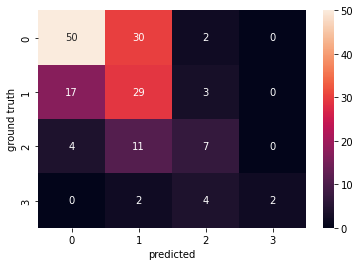

In [26]:
# confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_list2, y_preds2))
s = sns.heatmap(confusion_matrix_df, annot=True)
s.set(ylabel='ground truth', xlabel='predicted')

In [27]:
# classification report
print(classification_report(y_list2, y_preds2))

              precision    recall  f1-score   support

         0.0       0.70      0.61      0.65        82
         1.0       0.40      0.59      0.48        49
         2.0       0.44      0.32      0.37        22
         3.0       1.00      0.25      0.40         8

    accuracy                           0.55       161
   macro avg       0.64      0.44      0.48       161
weighted avg       0.59      0.55      0.55       161



In [28]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_target, y_predicted, class_label, guideline=False):
    fpr, tpr, threshold = metrics.roc_curve(y_target, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, label='%d: AUC = %0.2f' % (class_label, roc_auc))
    plt.legend(loc='lower right')
    if guideline:
        plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

def roc_auc_score_multiclass(actual_class, pred_class, average="macro", guideline=False):
    
    # create a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    
    for per_class in unique_class:
        
        # create a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]
        
        # mark the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        
        # calculate the roc_auc score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        
        plot_roc_curve(new_actual_class, new_pred_class, per_class, guideline)
        
    plt.show()
        
    return roc_auc_dict

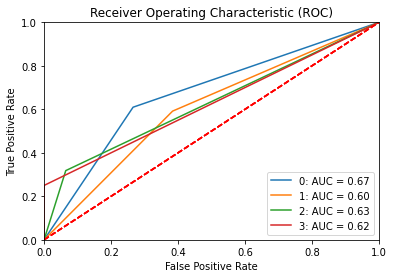

{0.0: 0.6719666563754246,
 1.0: 0.6039540816326531,
 2.0: 0.6267168083714846,
 3.0: 0.625}

In [29]:
roc_auc_dict = roc_auc_score_multiclass(y_list2, y_preds2, guideline=True)
roc_auc_dict

In [ ]:
#### model: custom simple net ####
model = ShallowNet(depth=1, classes=4)
model.to(device)
model.load_state_dict(torch.load('pretrained/221129_4classtest0.2x16noaug_epoch30'))
##################################